Download the CSV from wandb:

Filter the CSV for the important columns:

In [2]:
import pandas as pd

# Load the CSV data
results_df = pd.read_csv('errorgen_results.csv')

# Print dtypes of the columns
print(results_df.dtypes)

name                                      object
model_type                                object
test_MeanSquaredError                    float64
test_MeanAbsolutePercentageError         float64
errorgen_columns                          object
errorgen_missing_values                     bool
errorgen_missing_values_rate             float64
errorgen_missing_values_no_imputation       bool
errorgen_outliers                           bool
errorgen_outliers_rate                   float64
errorgen_outliers_coefficient            float64
errorgen_outliers_noise_coeff            float64
errorgen_clipping                           bool
errorgen_clipping_rate                   float64
errorgen_clipping_lower_quantile         float64
errorgen_clipping_upper_quantile         float64
inference_model_path                      object
dtype: object


Filter out the models that where not fully checked:

In [3]:
counts = results_df['inference_model_path'].value_counts()
filtered_df = results_df[results_df['inference_model_path'].isin(counts[counts == 612].index)]

display(filtered_df.groupby('model_type')['inference_model_path'].nunique())
filtered_df.to_csv("errorgen_results_filtered.csv", index=False)

model_type
deepar         100
lstm           100
nhits          100
tcn            100
tft            100
transformer    100
Name: inference_model_path, dtype: int64

## Start the analysis of the results:

In [4]:
results_df = results_df.dropna(subset=['test_MeanSquaredError', 'model_type'])
results_df[results_df['model_type'] == 'lstm'].head()

,name,model_type,test_MeanSquaredError,test_MeanAbsolutePercentageError,errorgen_columns,errorgen_missing_values,errorgen_missing_values_rate,errorgen_missing_values_no_imputation,errorgen_outliers,errorgen_outliers_rate,errorgen_outliers_coefficient,errorgen_outliers_noise_coeff,errorgen_clipping,errorgen_clipping_rate,errorgen_clipping_lower_quantile,errorgen_clipping_upper_quantile,inference_model_path
61200,lstm_2025-01-10_18-56-19,lstm,0.578020,2.210196,['PV_25_Fuellstand_RRB_ival'],False,NaN,False,False,NaN,1.1,0.1,True,0.5,0.2,0.8,all_trained_models/global/lstm/2024-12-20_19_1...
61201,lstm_2025-01-10_18-55-50,lstm,0.580100,2.208634,['PV_25_Fuellstand_RRB_ival'],False,NaN,False,False,NaN,1.1,0.1,True,0.4,0.2,0.8,all_trained_models/global/lstm/2024-12-20_19_1...
61202,lstm_2025-01-10_18-55-20,lstm,0.581513,2.217634,['PV_25_Fuellstand_RRB_ival'],False,NaN,False,False,NaN,1.1,0.1,True,0.3,0.2,0.8,all_trained_models/global/lstm/2024-12-20_19_1...
61203,lstm_2025-01-10_18-54-50,lstm,0.583900,2.218052,['PV_25_Fuellstand_RRB_ival'],False,NaN,False,False,NaN,1.1,0.1,True,0.2,0.2,0.8,all_trained_models/global/lstm/2024-12-20_19_1...
61204,lstm_2025-01-10_18-54-21,lstm,0.586355,2.217408,['PV_25_Fuellstand_RRB_ival'],False,NaN,False,False,NaN,1.1,0.1,True,0.1,0.2,0.8,all_trained_models/global/lstm/2024-12-20_19_1...


In [5]:
model_type = 'tft'
unique_columns = results_df['errorgen_columns'].unique()

model_name_dict = {
    'lstm': 'LSTM',
    'tft': 'TFT',
    'transformer': 'Transformer',
    'tcn': 'TCN',
    'deepar': 'DeepAR',
    'nhits': 'N-HiTS'
}

sorted_columns_dict = {}

Wichtig! Gleiche X-Skala für alle Bar-Plots! Oder Relative Werte. Die Bar Plots auf eine Seite packen mit 3 Zeilen und 2 Spalten.

{'lstm': 0.002315540503719539,
 'deepar': 0.004028937132754473,
 'tcn': 0.0007313146280970718,
 'transformer': 0.0015046459532138037,
 'nhits': 0.000998239456525359,
 'tft': 0.001005827807657904}

{'lstm': [0.0006527862909131857, 0.0023334171957403115],
 'deepar': [0.0005816485915481562, 0.006497402532511971],
 'tcn': [6.563285107353822e-05, 0.0004884456169901019],
 'transformer': [8.656793645555976e-05, 0.0008897689470653354],
 'nhits': [0.00016970201690419406, 0.0011959324501424082],
 'tft': [8.821841200519857e-05, 0.0005746263425052134]}

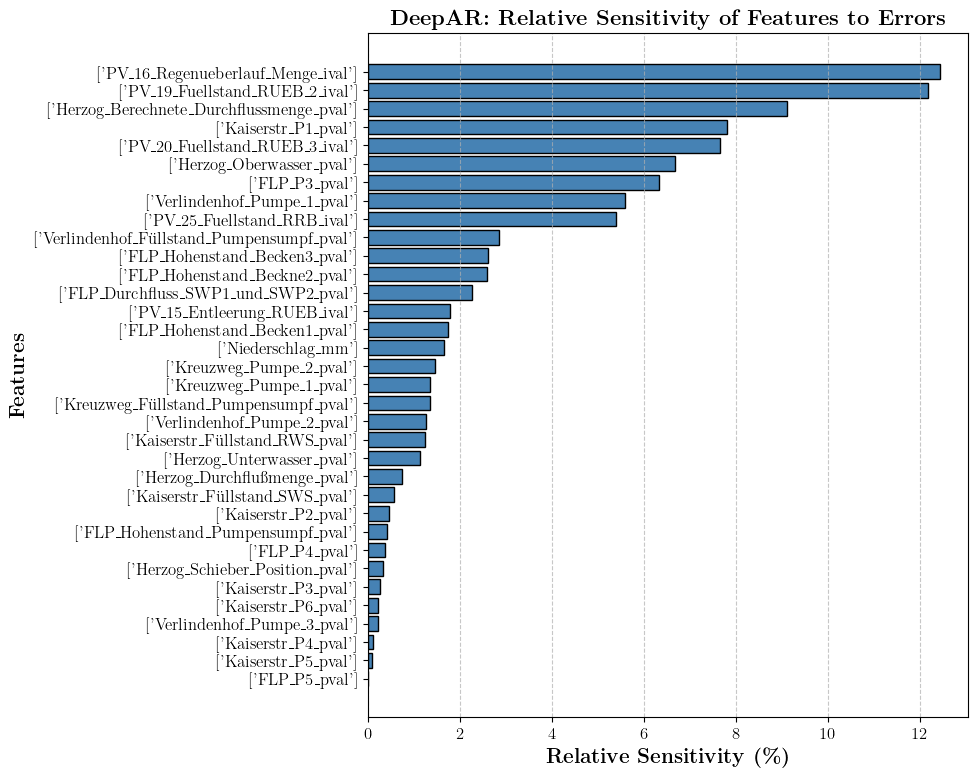

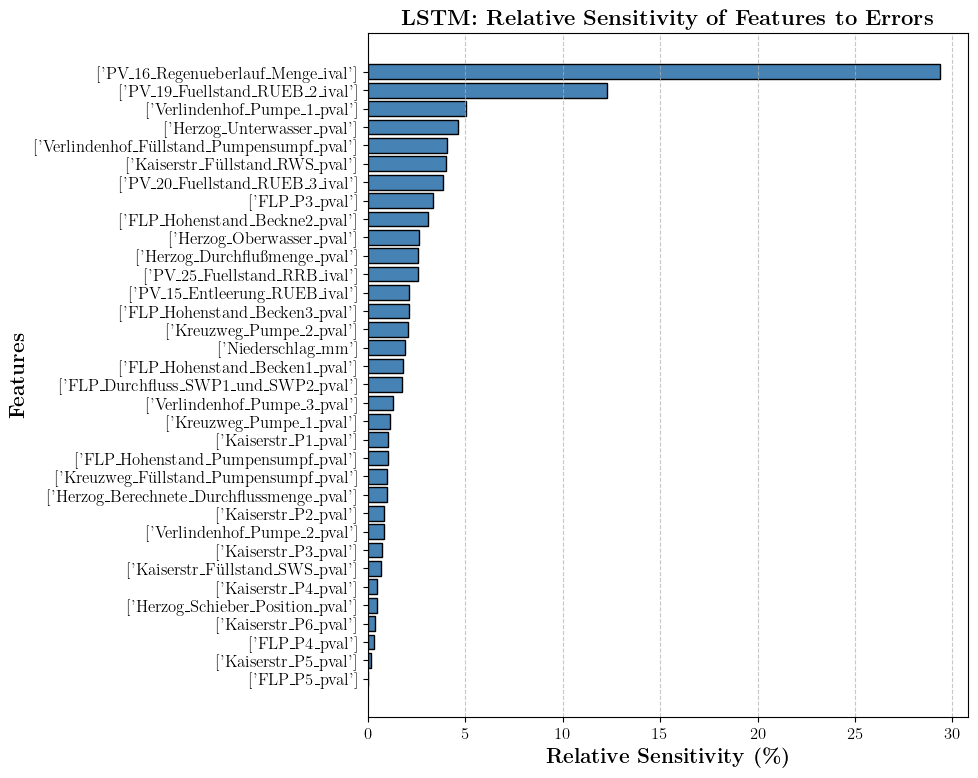

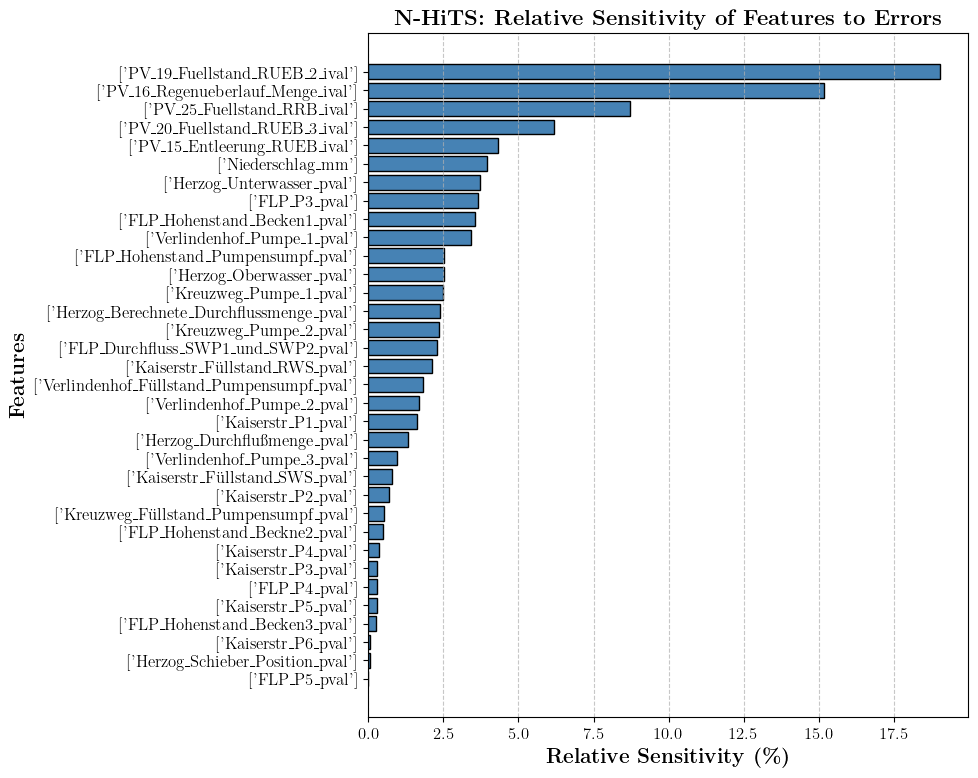

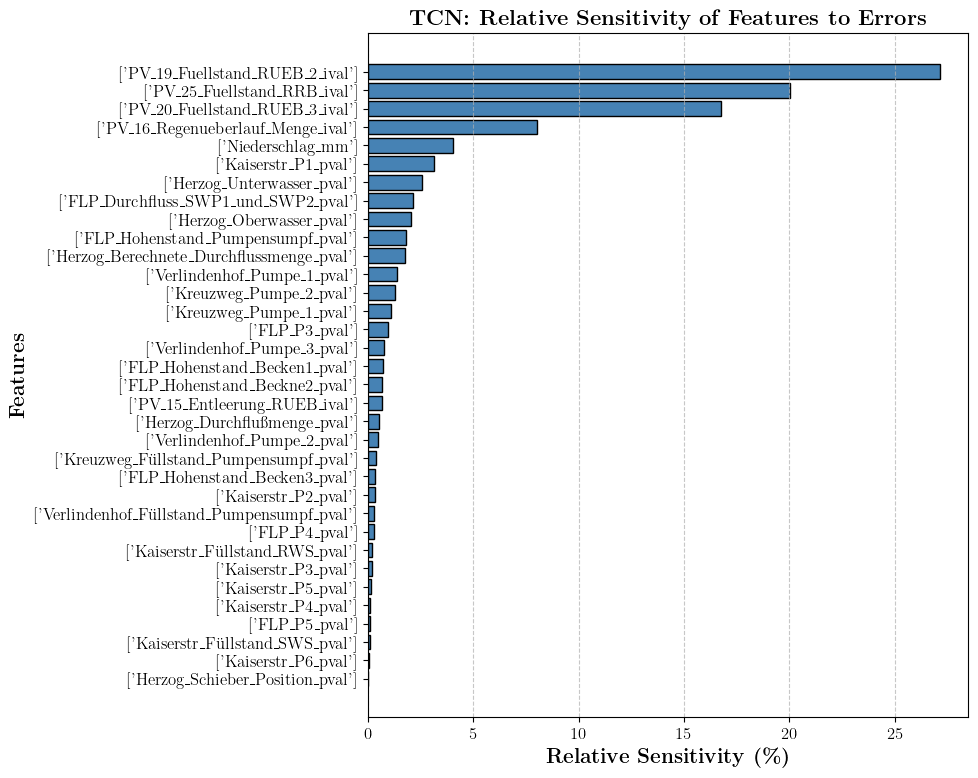

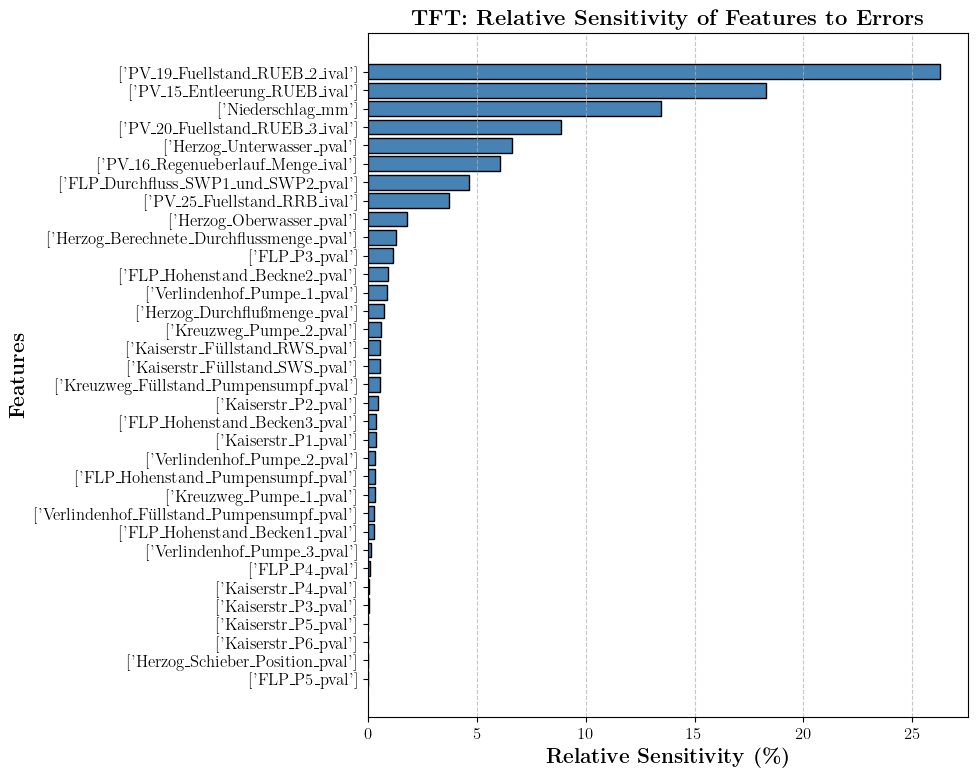

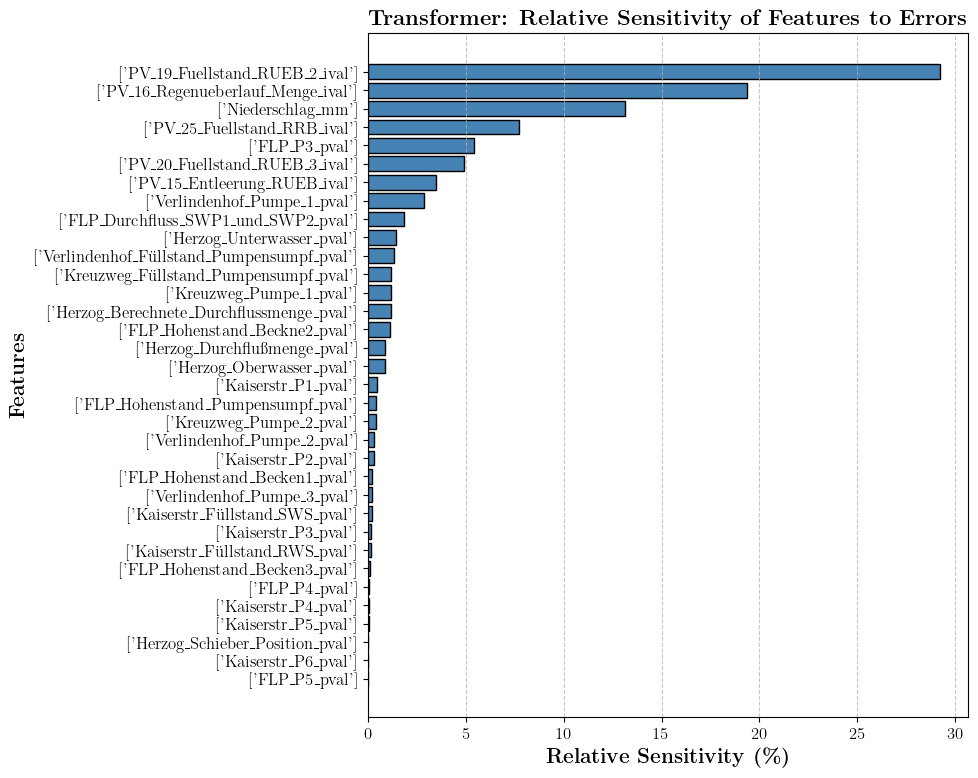

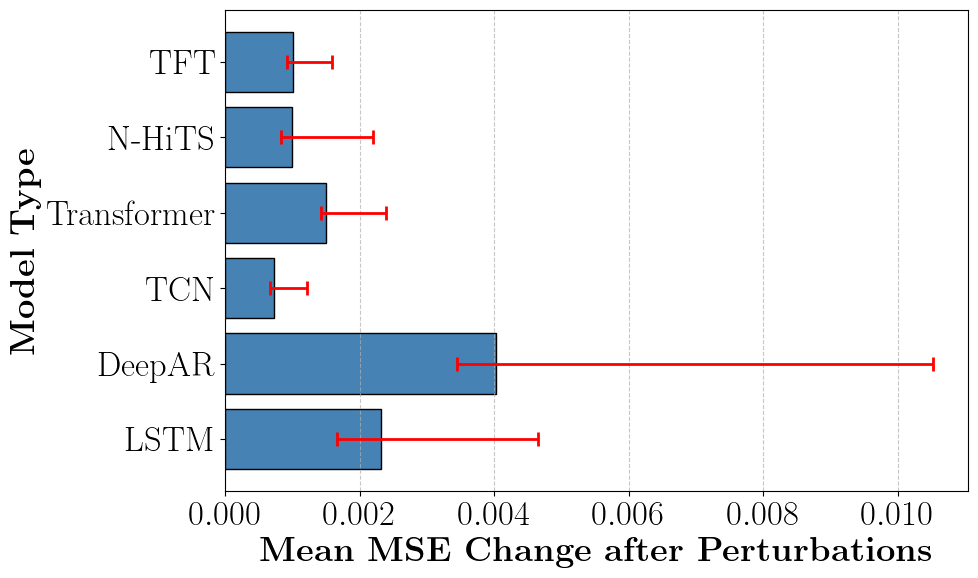

In [19]:
# Re-importing necessary libraries and recreating the plot with error bars instead of boxplots
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import rc

# Set the font to Computer Modern
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

model_plots = {}
max_xlim = 0

model_mean_diff_dict = {}
model_iqr_diff_dict = {}
model_median_diff_dict = {}

for model_type in results_df['model_type'].unique():
    # Calculate the mean difference in MSE values for each column compared to error rate 0.0
    mean_difference_values = []
    total_diff = 0
    
    for column in unique_columns:
        filtered_df = results_df[(results_df['model_type'] == model_type) & (results_df['errorgen_columns'] == column)]
        mse_values_rate_0 = filtered_df[(filtered_df['errorgen_missing_values_rate'] == 0.0) |
                                        (filtered_df['errorgen_outliers_rate'] == 0.0) |
                                        (filtered_df['errorgen_clipping_rate'] == 0.0)]['test_MeanSquaredError'].mean()
        mean_diff = 0
        count = 0
        for rate_column in ['errorgen_missing_values_rate', 'errorgen_outliers_rate', 'errorgen_clipping_rate']:
            for rate in filtered_df[rate_column].unique():
                if rate != 0.0 and not pd.isna(rate):
                    mse_values_rate = filtered_df[filtered_df[rate_column] == rate]['test_MeanSquaredError'].mean()
                    mean_diff += abs(mse_values_rate - mse_values_rate_0)
                    count += 1
        mean_difference = mean_diff / count if count > 0 else 0
        mean_difference_values.append(mean_difference)
        total_diff += mean_difference

    relative_error_sensitivty = [100 * (diff / total_diff) for diff in mean_difference_values]
    
    # Filter out columns with NaN mean differences
    valid_columns = [(col, diff) for col, diff in zip(unique_columns, relative_error_sensitivty) if not pd.isna(diff)]
    sorted_columns = [col for col, _ in sorted(valid_columns, key=lambda x: x[1], reverse=True)]
    sorted_columns_dict[model_type] = sorted_columns
    sorted_mean_difference_values = [diff for _, diff in sorted(valid_columns, key=lambda x: x[1], reverse=True)]

    # Create a bar plot with y-axis as the columns and x-axis as the mean difference
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Plot the bars horizontally with the largest mean difference at the top
    ax.barh(sorted_columns, sorted_mean_difference_values, color='steelblue', edgecolor='black')
    ax.invert_yaxis()  # Invert y-axis to have the largest mean difference at the top

    # Set labels and title
    ax.set_xlabel('\\textbf{Relative Sensitivity (\%)}', fontsize=15)
    ax.set_ylabel('\\textbf{Features}', fontsize=15)
    ax.set_title('\\textbf{' + f'{model_name_dict[model_type]}: ' + 'Relative Sensitivity of Features to Errors' + '}', fontsize=16)

    # Add grid lines for better readability
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    fig.tight_layout(pad=1.5)

    max_xlim = max(max_xlim, ax.get_xlim()[1])
    model_plots[model_type] = (fig, ax)
    model_mean_diff_dict[model_type] = np.mean(mean_difference_values)
    model_iqr_diff_dict[model_type] = [np.percentile(mean_difference_values, 25), np.percentile(mean_difference_values, 75)]
    model_median_diff_dict[model_type] = np.median(mean_difference_values)
    
# Reiterate over plots to set xlim and save the figures
for model_type in model_plots.keys():
    fig, ax = model_plots[model_type]
    # ax.set_xscale('log')
    # ax.set_xlim(0, max_xlim)
    fig.savefig(f'plots/rel_feature_sensitivity_plots/rel_feature_sensitivity_{model_type}.pdf', format='pdf')
    
# Plot the mean diff dict to compare the models
error_kwargs = dict(elinewidth=2, capsize=5, capthick=2)
fig, ax = plt.subplots(figsize=(10, 6))

# Adjust model_type sorting of model_mean_diff_dict
sorting = ['tft', 'nhits', 'transformer', 'tcn', 'deepar', 'lstm']
model_mean_diff_dict = {model_type: model_mean_diff_dict[model_type] for model_type in reversed(sorting)}
model_iqr_diff_dict = {model_type: model_iqr_diff_dict[model_type] for model_type in reversed(sorting)}

# Plotting
ax.barh([model_name_dict[model_type] for model_type in model_mean_diff_dict.keys()], list(model_mean_diff_dict.values()), xerr=np.transpose(list(model_iqr_diff_dict.values())), ecolor='red', error_kw=error_kwargs, color='steelblue', edgecolor='black')
ax.set_xlabel('\\textbf{Mean MSE Change after Perturbations}', fontsize=25)
ax.set_ylabel('\\textbf{Model Type}', fontsize=25)

# Increase font size of the labels
ax.tick_params(axis='both', which='major', labelsize=25)

# ax.set_title('\\textbf{Model Type Comparison: Sensitivity to Errors}', fontsize=16)

# Add grid lines for better readability
ax.grid(axis='x', linestyle='--', alpha=0.7)
fig.tight_layout(pad=1.5)

fig.savefig('plots/model_comparison.pdf', format='pdf')

display(model_mean_diff_dict)
display(model_iqr_diff_dict)


In [ ]:
# Re-importing necessary libraries and recreating the plot with error bars instead of boxplots
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

# Replot the figure with error bars only
fig, axes = plt.subplots(nrows=(len(unique_columns) + 1) // 2, ncols=2, figsize=(15, 6 * ((len(unique_columns) + 1) // 2)))

axes = axes.flatten()

# Define different colors for each error type and their corresponding line color
line_colors = {
    'errorgen_missing_values': 'blue',
    'errorgen_outliers': 'green',
    'errorgen_clipping': 'red'
}

list_q1 = []
list_q3 = []

for idx, column in enumerate(unique_columns):
    filtered_df = results_df[(results_df['model_type'] == model_type) & (results_df['errorgen_columns'] == column)]
        
    ax = axes[idx]

    for error_type, rate_column in zip(
        ['errorgen_missing_values', 'errorgen_outliers', 'errorgen_clipping'],
        ['errorgen_missing_values_rate', 'errorgen_outliers_rate', 'errorgen_clipping_rate']
    ):
        # Filter the data for the current error type
        filtered_df_error = filtered_df[filtered_df[error_type]]

        # Get the unique error rates directly from the DataFrame
        unique_error_rates = sorted(filtered_df_error[rate_column].dropna().unique())  # Filter out any NaN values
        
        # Collect MSE values for each error rate
        mse_values = [
            filtered_df_error[filtered_df_error[rate_column] == rate]['test_MeanSquaredError'].dropna()
            for rate in unique_error_rates
        ]
        
        # Filter out any empty mse values and their corresponding rates
        valid_mse_values = [mse for mse in mse_values if not mse.empty]
        valid_positions = [float(rate) for rate, mse in zip(unique_error_rates, mse_values) if not mse.empty]  # Convert to float
        
        # Calculate the median and IQR (Q1, Q3) for the error bars
        if valid_mse_values:
            medians = [mse.median() for mse in valid_mse_values]
            q1 = [mse.quantile(0.25) for mse in valid_mse_values]
            q3 = [mse.quantile(0.75) for mse in valid_mse_values]
            
            # Append for later y axis limit calculation
            list_q1.append(q1)
            list_q3.append(q3)
            
            # The error bar is calculated as the difference between the median and Q1/Q3
            lower_error = [med - q for med, q in zip(medians, q1)]
            upper_error = [q - med for q, med in zip(q3, medians)]
            asymmetric_error = [lower_error, upper_error]
            
            # Plot error bars using the medians and IQR
            ax.errorbar(valid_positions, medians, yerr=asymmetric_error, fmt='o-', color=line_colors[error_type], label=error_type)
    
    # Set x-axis limits to ensure it's continuous from -0.1 to 0.6
    ax.set_xlim(-0.1, 0.6)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylabel('Mean Squared Error', fontsize=14)
    ax.set_xlabel('Error Rate', fontsize=14)
    ax.set_title(f'{column}', fontsize=16)  # Only column name as title
    ax.tick_params(axis='both', which='major', labelsize=12)# Create proxy artists (lines) for the legend

lower_limit = (np.floor(10 * np.min(list_q1)) / 10) - 0.05
upper_limit = (np.ceil(10 * np.max(list_q3)) / 10) + 0.05

# Set unified y-axis limits based on IQR-filtered data
for ax in axes:
    ax.set_ylim(lower_limit, upper_limit)

legend_elements = [Line2D([0], [0], color='blue', marker='o', label='Missing Values'),
                   Line2D([0], [0], color='green', marker='o', label='Outliers'),
                   Line2D([0], [0], color='red', marker='o', label='Clipping')]

# Add the legend to the figure using the line elements
fig.legend(handles=legend_elements, loc='upper center', ncol=3, fontsize=12, title='Error Types', title_fontsize='13')

# Remove any unused subplots
for i in range(len(unique_columns), len(axes)):
    fig.delaxes(axes[i])

# Add a main title to the figure
fig.suptitle(f'{model_type.upper()} - Error Rates vs Mean Squared Error Analysis', fontsize=20, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main title and legend

plt.subplots_adjust(wspace=0.15, hspace=0.25)

plt.show()

In [207]:
model_type = 'nhits'


Vielleicht auch hier alle aggregierten Errorplots auf eine Seite mit 3 Zeilen und 2 Spalten.

In [ ]:
# Re-importing necessary libraries and recreating the plot with aggregated MSE values per error rate and error type
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define different colors for each error type and their corresponding line color
error_colors = {
    'errorgen_missing_values': 'lightblue',
    'errorgen_outliers': 'lightgreen',
    'errorgen_clipping': 'lightcoral'
}
line_colors = {
    'errorgen_missing_values': 'blue',
    'errorgen_outliers': 'green',
    'errorgen_clipping': 'red'
}

model_figures_dict = {}
max_y_range = 0

for model_type in results_df['model_type'].unique():
    title = '\\textbf{' + f'{model_name_dict[model_type]} - Feature with highest sensitivity to errors' + '}'
    
    fig, ax = plt.subplots(figsize=(10, 7))
    model_figures_dict[model_type] = (fig, ax)

    for error_type, rate_column in zip(
        ['errorgen_missing_values', 'errorgen_outliers', 'errorgen_clipping'],
        ['errorgen_missing_values_rate', 'errorgen_outliers_rate', 'errorgen_clipping_rate']
    ):
        # CHANGE THE SUBSETTING FOR FEATURES HERE
        # Filter the data for the current error type and only use the top x columns
        top_column = sorted_columns_dict.get(model_type, [])[:1]
        filtered_df_error = results_df[
            (results_df['model_type'] == model_type) &
            (results_df[error_type]) &
            (results_df['errorgen_columns'].isin(top_column))
        ]

        # Get the unique error rates directly from the DataFrame
        unique_error_rates = sorted(filtered_df_error[rate_column].dropna().unique())  # Filter out any NaN values
        
        # Collect MSE values for each error rate
        mse_values = [
            filtered_df_error[filtered_df_error[rate_column] == rate]['test_MeanSquaredError'].dropna()
            for rate in unique_error_rates
        ]
        
        # Filter out any empty mse values and their corresponding rates
        valid_mse_values = [mse for mse in mse_values if not mse.empty]
        valid_positions = [float(rate) for rate, mse in zip(unique_error_rates, mse_values) if not mse.empty]  # Convert to float
        
        # Calculate the median and IQR (Q1, Q3) for the error bars
        if valid_mse_values:
            medians = [mse.median() for mse in valid_mse_values]
            q1 = [mse.quantile(0.25) for mse in valid_mse_values]
            q3 = [mse.quantile(0.75) for mse in valid_mse_values]
            
            # The error bar is calculated as the difference between the median and Q1/Q3
            lower_error = [med - q for med, q in zip(medians, q1)]
            upper_error = [q - med for q, med in zip(q3, medians)]
            asymmetric_error = [lower_error, upper_error]
            
            # Plot error bars using the medians and IQR
            ax.errorbar(valid_positions, medians, yerr=asymmetric_error, fmt='o-', color=line_colors[error_type], label=error_type)

    # Set x-axis limits to ensure it's continuous from -0.05 to 0.55
    ax.set_xlim(-0.05, 0.55)

    # Set labels and title
    ax.set_xlabel('\\textbf{Error Rate}', fontsize=15)
    ax.set_ylabel('\\textbf{Mean Squared Error}', fontsize=15)
    ax.set_title(f'{model_name_dict[model_type]} - Aggregated Error Rates vs Mean Squared Error Analysis' if title is None else title, fontsize=16)

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    max_y_range = max(max_y_range, ax.get_ylim()[1] - ax.get_ylim()[0])

for model_type in model_figures_dict.keys():
    fig, ax = model_figures_dict[model_type]
    
    # Normalizte the y-scale
    # y_mid = (ax.get_ylim()[1] + ax.get_ylim()[0]) / 2
    # y_min, y_max = y_mid - (max_y_range / 2), y_mid + (max_y_range / 2)
    # ax.set_ylim(y_min, y_max)
    fig.savefig(f'error_rate_mse_plots/{model_type}_highest_sens_error_rate_mse.pdf', format='pdf')

In [229]:
# Create proxy artists (lines) for the legend
legend_elements = [Line2D([0], [0], color='blue', marker='o', label='Missing Values'),
                   Line2D([0], [0], color='green', marker='o', label='Outliers'),
                   Line2D([0], [0], color='red', marker='o', label='Clipping')]

# Save the figure legend to separate file
fig_legend = plt.figure(figsize=(4.55, 0.65))
fig_legend.legend(handles=legend_elements, loc='center', ncol=3, fontsize=12, title='Error Types', title_fontsize='13')
fig_legend.savefig('error_rate_mse_plots/error_rate_mse_legend.pdf', format='pdf')

<Figure size 455x65 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define different colors for each error type and their corresponding line color
line_colors = {
    'errorgen_missing_values': 'blue',
    'errorgen_outliers': 'green',
    'errorgen_clipping': 'red'
}

model_figures_dict = {}
max_y_range = 0

for model_type in results_df['model_type'].unique():
    title = '\\textbf{' + f'\textbf{{{model_name_dict[model_type]} - MSE Percentage Increase for Most Sensitive Feature}}' + '}'
    
    fig, ax = plt.subplots(figsize=(10, 7))
    model_figures_dict[model_type] = (fig, ax)

    for error_type, rate_column in zip(
        ['errorgen_missing_values', 'errorgen_outliers', 'errorgen_clipping'],
        ['errorgen_missing_values_rate', 'errorgen_outliers_rate', 'errorgen_clipping_rate']
    ):
        # Filter the data for the current error type
        top_column = sorted_columns_dict.get(model_type, [])[:1]
        filtered_df_error = results_df[
            (results_df['model_type'] == model_type) &
            (results_df[error_type]) &
            (results_df['errorgen_columns'].isin(top_column))
        ]
        
        # Get the unique error rates directly from the DataFrame
        unique_error_rates = sorted(filtered_df_error[rate_column].dropna().unique())  # Filter out any NaN values
        
        # Calculate relative increase in MSE for each model separately
        relative_increases = []
        for model_path in filtered_df_error['inference_model_path'].unique():
            model_df = filtered_df_error[filtered_df_error['inference_model_path'] == model_path]
            baseline_mse = model_df[model_df[rate_column] == 0.0]['test_MeanSquaredError'].mean()
            
            if np.isnan(baseline_mse) or baseline_mse == 0:
                print(f"Skipping model {model_path} as baseline MSE is NaN or 0")
                continue
            
            relative_percentage_increase = [
                ((model_df[model_df[rate_column] == rate]['test_MeanSquaredError'].mean() / baseline_mse) - 1) * 100
                for rate in unique_error_rates
            ]
            relative_increases.append(relative_percentage_increase)
        
        # Convert list of lists to numpy array for easy manipulation
        relative_increases = np.array(relative_increases)
        
        # Calculate the median and IQR (Q1, Q3) for the error bars
        if len(relative_increases) > 0:
            medians = np.nanmedian(relative_increases, axis=0)
            q1 = np.nanquantile(relative_increases, 0.25, axis=0)
            q3 = np.nanquantile(relative_increases, 0.75, axis=0)
            
            # The error bar is calculated as the difference between the median and Q1/Q3
            lower_error = medians - q1
            upper_error = q3 - medians
            asymmetric_error = [lower_error, upper_error]
            
            # Plot error bars using the medians and IQR
            ax.errorbar([100 * rate for rate in unique_error_rates], medians, yerr=asymmetric_error, fmt='o-', color=line_colors[error_type], label=error_type)

    # Set x-axis limits to ensure it's continuous from -0.05 to 0.55
    ax.set_xlim(-2, 52)

    # Set labels and title
    ax.set_xlabel('\\textbf{Error Rate (\%)}', fontsize=15)
    ax.set_ylabel('\\textbf{Relative Increase in MSE (\%)}', fontsize=15)
    ax.set_title('\\textbf{' + f'{model_name_dict[model_type]} - Relative Increase in MSE with Different Error Rates' + '}', fontsize=16)

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    max_y_range = max(max_y_range, ax.get_ylim()[1] - ax.get_ylim()[0])

for model_type in model_figures_dict.keys():
    fig, ax = model_figures_dict[model_type]
    
    # Normalize the y-scale
    # y_mid = (ax.get_ylim()[1] + ax.get_ylim()[0]) / 2
    # y_min, y_max = y_mid - (max_y_range / 2), y_mid + (max_y_range / 2)
    # ax.set_ylim(y_min, y_max)
    fig.savefig(f'relative_increase_plots/{model_type}_relative_increase_mse.pdf', format='pdf')

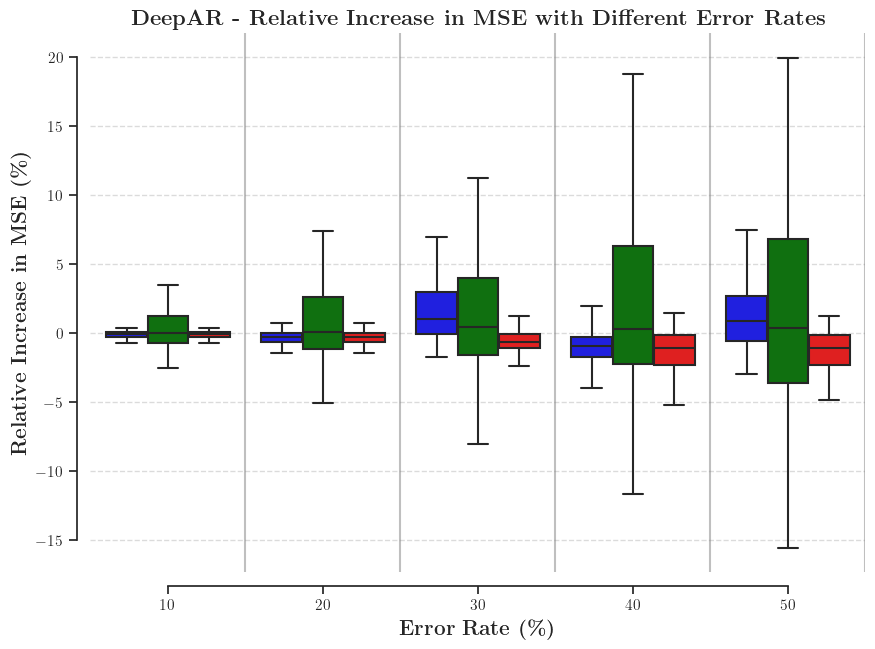

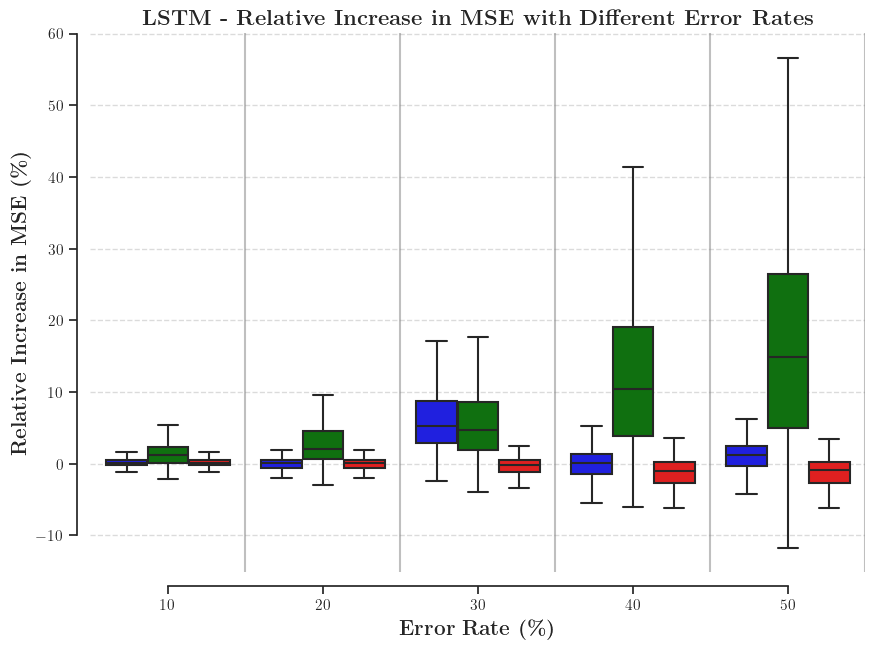

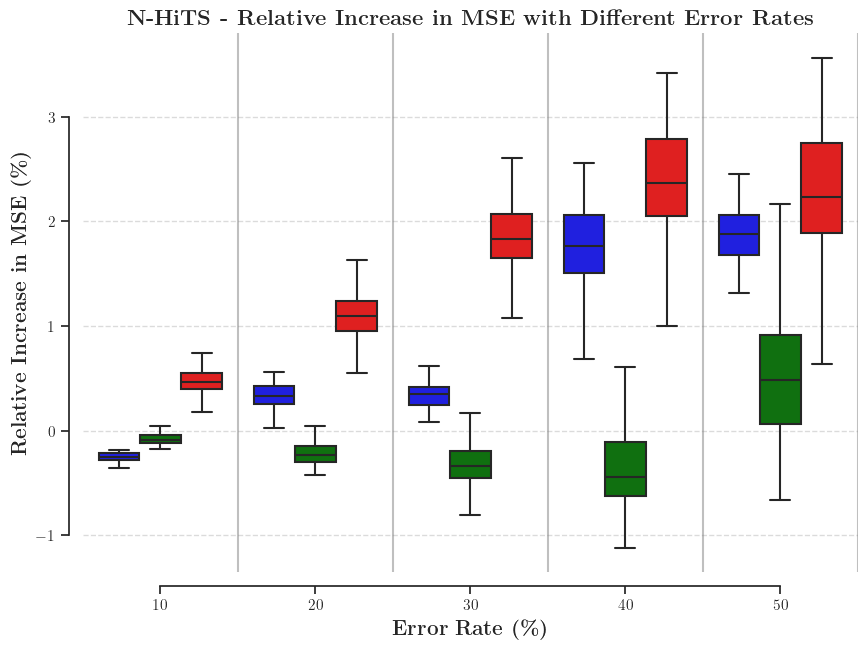

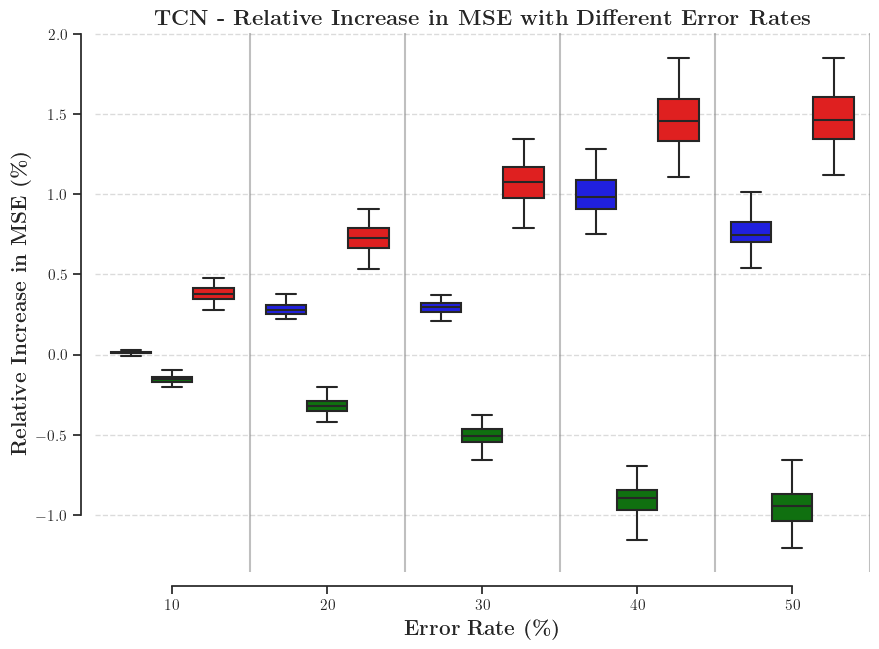

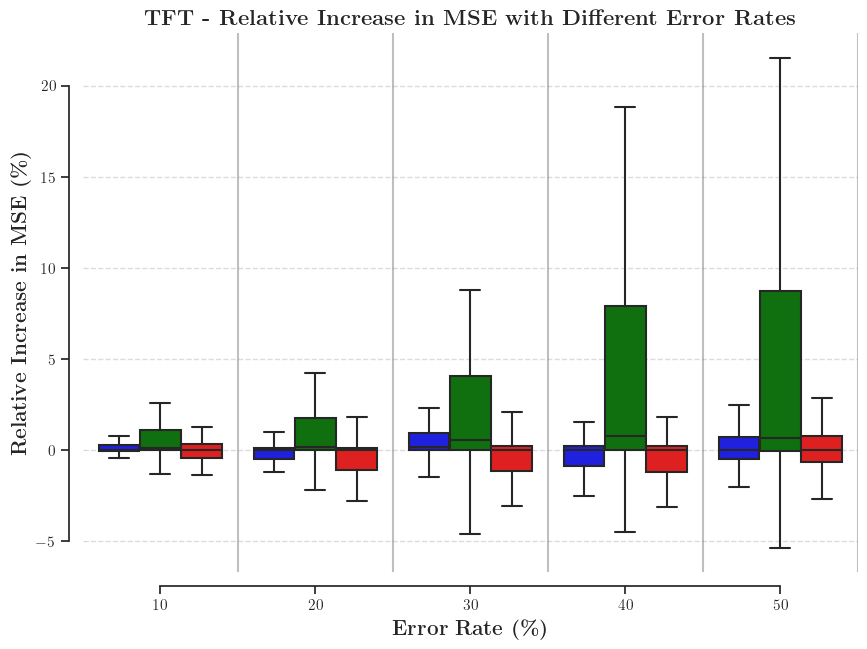

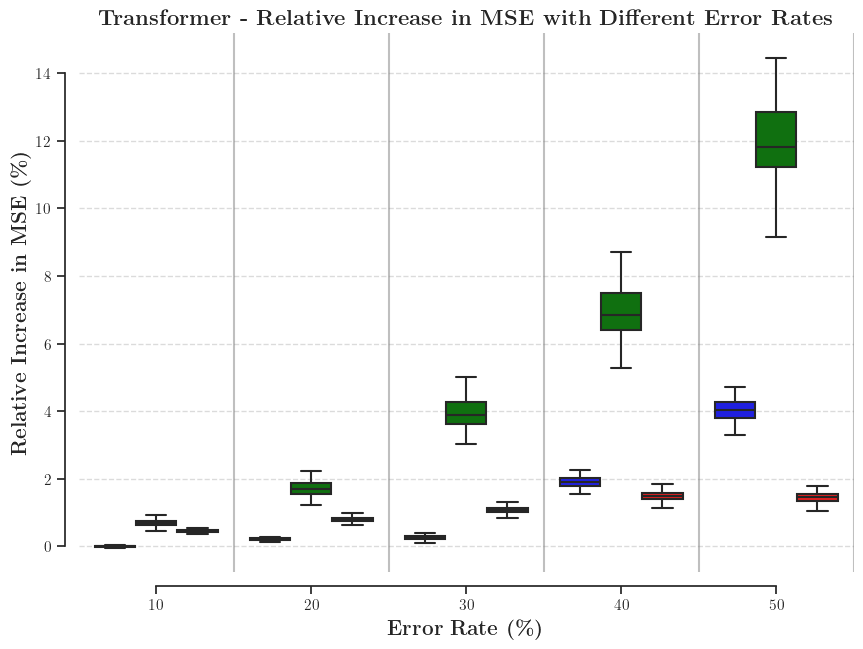

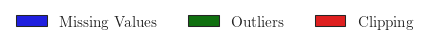

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Set the seaborn theme
sns.set_theme(style="ticks", palette="pastel")

# Set the font to Computer Modern with serifs
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Define different colors for each error type
error_colors = {
    'errorgen_missing_values': 'blue',
    'errorgen_outliers': 'green',
    'errorgen_clipping': 'red'
}

model_figures_dict = {}

for model_type in results_df['model_type'].unique():    
    fig, ax = plt.subplots(figsize=(10, 7))
    model_figures_dict[model_type] = (fig, ax)

    # Prepare data for seaborn boxplot
    plot_data = []
    for error_type, rate_column in zip(
        ['errorgen_missing_values', 'errorgen_outliers', 'errorgen_clipping'],
        ['errorgen_missing_values_rate', 'errorgen_outliers_rate', 'errorgen_clipping_rate']
    ):
        # Filter the data for the current error type
        top_column = sorted_columns_dict.get(model_type, [])[:1]
        filtered_df_error = results_df[
            (results_df['model_type'] == model_type) &
            (results_df[error_type]) &
            (results_df['errorgen_columns'].isin(top_column))
        ]
        
        # Get the unique error rates directly from the DataFrame
        unique_error_rates = sorted(filtered_df_error[rate_column].dropna().unique())  # Filter out any NaN values
        
        # Calculate relative increase in MSE for each model separately
        for rate in [r for r in unique_error_rates if r != 0.0]:
            for model_path in filtered_df_error['inference_model_path'].unique():
                model_df = filtered_df_error[filtered_df_error['inference_model_path'] == model_path]
                baseline_mse = model_df[model_df[rate_column] == 0.0]['test_MeanSquaredError'].mean()
                
                if np.isnan(baseline_mse) or baseline_mse == 0:
                    continue
                
                mse_at_rate = model_df[model_df[rate_column] == rate]['test_MeanSquaredError'].mean()
                relative_percentage_increase = ((mse_at_rate / baseline_mse) - 1) * 100
                
                plot_data.append({
                    'Error Rate': (int)(100 * rate),
                    'Percentage Increase in MSE': relative_percentage_increase,
                    'Error Type': error_type
                })

    # Convert plot data to DataFrame
    plot_df = pd.DataFrame(plot_data)

    # Plot using seaborn
    sns.boxplot(x='Error Rate', y='Percentage Increase in MSE', hue='Error Type', palette=error_colors, data=plot_df, ax=ax, dodge=True, showfliers=False)
    ax.get_legend().remove()
    
    sns.despine(offset=10, trim=True)

    # Set labels and title
    ax.set_xlabel('\\textbf{Error Rate (\%)}', fontsize=15)
    ax.set_ylabel('\\textbf{Relative Increase in MSE (\%)}', fontsize=15)
    ax.set_title('\\textbf{' + f'{model_name_dict[model_type]} - Relative Increase in MSE with Different Error Rates' + '}', fontsize=16)

    # Add grid lines for better readability
    ax.grid(True, linestyle='--', alpha=0.7, axis='y')
    
    # Add vertical lines to separate groups
    for x in np.arange(0.5, len(plot_df['Error Rate'].unique()), 1):
        ax.axvline(x, color='grey', linestyle='-', alpha=0.5)

    fig.savefig(f'plots/relative_increase_boxplots/{model_type}_relative_increase_mse.pdf', format='pdf')

# Save legend as a separate file
legend_fig = plt.figure(figsize=(4.7, 0.25))
legend_ax = legend_fig.add_subplot(111)
handles, labels = ax.get_legend_handles_labels()
labels = ['Missing Values' if label == 'errorgen_missing_values' else 'Outliers' if label == 'errorgen_outliers' else 'Clipping' for label in labels]
legend_ax.legend(handles, labels, loc='center', frameon=False, ncol=len(labels))
legend_ax.axis('off')
legend_fig.savefig('plots/relative_increase_boxplots/legend.pdf', format='pdf')